# NLP on Place du marche

- dataset is 1050 csv on kaggle

In [1]:
RANDOM_SEED = 1359 # for models

In [2]:
import os
import sys
import json
import yaml

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("/kaggle/input/flipkart/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

In [5]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


# Etape 1

- Réalisez au préalable un prétraitement de vos textes : nettoyage, stemming, lemmatization etc. 
- Utilisez des méthodes basiques d’encodage de texte (Bag of Words, TfIdf etc.)
- Utilisez des méthodes de réduction de dimension sur le texte encodé et comparer les résultats avec les catégories réelles

# EDA

- TODO: do more here, check NANs etc

In [6]:
df.columns # we want 'description' only ? and maye also 'product_name' ?

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [7]:
# check i any products with missing description or product name
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

# Create the actual Category

- pas tres clair dans l'exercise
- en regardant les 2 images, on dirait que les Categories sont : "Home Furnishing", "Baby Care"

**J'AI REMARQUE QUE CA CORRESPOND AU "TOPLEVEL" DE `product_category_tree` -> confirme avec mentor TODO**

In [8]:
df.loc[:4, "product_category_tree"]

0    ["Home Furnishing >> Curtains & Accessories >>...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
Name: product_category_tree, dtype: object

In [9]:
import re

In [10]:
# try get the "main_product_cat" as the first one / top level
get_main_category = lambda example: re.findall("^.+?(?= >>|$)", example)[0]

df["main_product_category"] = df["product_category_tree"].apply(get_main_category)

In [11]:
df["main_product_category"].value_counts()

main_product_category
["Home Furnishing               150
["Baby Care                     150
["Watches                       150
["Home Decor & Festive Needs    150
["Kitchen & Dining              150
["Beauty and Personal Care      150
["Computers                     150
Name: count, dtype: int64

In [12]:
# !!!!!! ah the remove the [" O_o
df["main_product_category"] = df["main_product_category"].apply(lambda example: example[2:])

df["main_product_category"].value_counts()

main_product_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

## Text preprocessing

### Nettoyage

- tokenize
- remove punctuation
- lowercase
- remove digits

## Update

At first I used a word tokenizer from nltk but then I realised that the stopwords aren't acually compatible with the tokenizer (!?) since for example:

`you'll` is in `STOPWORDS_EN`

but...

`word_tokenize("you\'ll") --> ['you', "'ll"]`

in other words it won't be removed/filtered on stopwords criterion

**Therefore I will "Python `split()` tokenize my examples on space char**

In [13]:
from nltk import word_tokenize

sample = "you\'ll you'll test themselves"

print(word_tokenize(sample))

['you', "'ll", 'you', "'ll", 'test', 'themselves']


In [14]:
from nltk.corpus import stopwords

STOPWORDS_EN = stopwords.words("english")

STOPWORDS_EN

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
# convert to set for lookup

STOPWORDS_EN = set(STOPWORDS_EN)

In [16]:
from string import punctuation as PUNCT_EN

PUNCT_EN = set(PUNCT_EN)

PUNCT_EN

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [17]:
# testing that isalpha() behaves as expected

for test_x in ["a123", "141", "32v1341", "ok", "not_ok", "OkOKokOOKKKOKOK", "not.ok"]:
    print(test_x, ":", test_x.isalpha())

a123 : False
141 : False
32v1341 : False
ok : True
not_ok : False
OkOKokOOKKKOKOK : True
not.ok : False


In [18]:
def do_preprocessing(example: str) -> str:
    """
    Does the text preprocessing on the product descriptions.
    
    NOTE:
    
    Some of this can be optimized / done with regex but the idea here
    is to visualize and account for each step (also only 1050 rows so
    performance isn't priority yet O_o)
    """
    
    # -- tokenize --
    # UPDATE: see comments why we'll split on space char instead of word_tokenize
    tokenized_example = example.split(' ') # default is space but just to emphasize
    
    # -- process all words in the tokenized description:
    # 1. remove words which contain numbers
    # 2. remove punctuation and stopwords
    # 3. converts to LOWERCASE while iterating through also
    processed = [word.lower()
                 for word in tokenized_example
                 if (word.isalpha()) and (word not in PUNCT_EN) and (word not in STOPWORDS_EN)]
    
    return processed

In [19]:
test_preprocessing = df.loc[0, "description"]

display(test_preprocessing)

print("===")

display(do_preprocessing(test_preprocessing))

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

===


['key',
 'features',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'cm',
 'pack',
 'this',
 'curtain',
 'enhances',
 'look',
 'curtain',
 'made',
 'high',
 'quality',
 'polyester',
 'features',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'makes',
 'room',
 'environment',
 'romantic',
 'curtain',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'the',
 'surreal',
 'attention',
 'sure',
 'steal',
 'these',
 'contemporary',
 'eyelet',
 'valance',
 'curtains',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'rays',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'world',
 'draw',
 'close',
 'create',
 'special',
 'moments',
 'joyous',
 'beauty',
 'given',
 'soothing',
 'bring',
 'home',
 'elegant',
 'curtain',
 'softly',
 'filters',
 'light',
 'room',
 'get',
 '

### Stemming and lemmatization

- update: discussion mentor, good idea to keep the 2 so can see which one helps

In [20]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
 
lemmatizer = WordNetLemmatizer() # NLTK lemmatizes on nouns (POS='n') by default

stemmer = PorterStemmer()

In [21]:
#nltk.download("wordnet")

In [22]:
# needed this to get WordNet to work -.-
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [23]:
test_stem_and_lem = ["cat", "cats", "catty", "good", "goodest", "gooder", "best", "great", "better", "betters", "program","programs","programmer"]

for x in test_stem_and_lem:
    print(x, stemmer.stem(x), lemmatizer.lemmatize(x))

cat cat cat
cats cat cat
catty catti catty
good good good
goodest goodest goodest
gooder gooder gooder
best best best
great great great
better better better
betters better better
program program program
programs program program
programmer programm programmer


In [24]:
df["processed_description"] = df["description"].apply(do_preprocessing)

In [25]:
df.head(3)

# ok works
#df.loc[0, "processed_description"] 

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_product_category,processed_description
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,"[key, features, elegance, polyester, multicolo..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,"[specifications, sathiyas, cotton, bath, towel..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,"[key, features, eurospa, cotton, terry, face, ..."


In [26]:
def do_stemming(example):
    return [stemmer.stem(word) for word in example]

def do_lemmatization(example):
    return [lemmatizer.lemmatize(word) for word in example]

In [27]:
df["stemmed_description"] = df["processed_description"].apply(do_stemming)

In [28]:
df["lemmatized_description"] = df["processed_description"].apply(do_lemmatization)

In [29]:
df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_product_category,processed_description,stemmed_description,lemmatized_description
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,"[key, features, elegance, polyester, multicolo...","[key, featur, eleg, polyest, multicolor, abstr...","[key, feature, elegance, polyester, multicolor..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,"[specifications, sathiyas, cotton, bath, towel...","[specif, sathiya, cotton, bath, towel, bath, b...","[specification, sathiyas, cotton, bath, towel,..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,"[key, features, eurospa, cotton, terry, face, ...","[key, featur, eurospa, cotton, terri, face, to...","[key, feature, eurospa, cotton, terry, face, t..."


In [30]:
df1 = df[["main_product_category", "processed_description","stemmed_description", "lemmatized_description"]].copy()

df1.head()

,main_product_category,processed_description,stemmed_description,lemmatized_description
0,Home Furnishing,"[key, features, elegance, polyester, multicolo...","[key, featur, eleg, polyest, multicolor, abstr...","[key, feature, elegance, polyester, multicolor..."
1,Baby Care,"[specifications, sathiyas, cotton, bath, towel...","[specif, sathiya, cotton, bath, towel, bath, b...","[specification, sathiyas, cotton, bath, towel,..."
2,Baby Care,"[key, features, eurospa, cotton, terry, face, ...","[key, featur, eurospa, cotton, terri, face, to...","[key, feature, eurospa, cotton, terry, face, t..."
3,Home Furnishing,"[key, features, santosh, royal, fashion, cotto...","[key, featur, santosh, royal, fashion, cotton,...","[key, feature, santosh, royal, fashion, cotton..."
4,Home Furnishing,"[key, features, jaipur, print, cotton, floral,...","[key, featur, jaipur, print, cotton, floral, k...","[key, feature, jaipur, print, cotton, floral, ..."


## Bag-of-words

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [32]:
def get_bag_of_words(description_col: str,
                     dataframe,
                     return_toarray=False
                    ):
    count_vectorizer = CountVectorizer()
    
    bag_of_words = count_vectorizer.fit_transform(dataframe[description_col])
    
    if return_toarray:
        return bag_of_words.toarray()
    else:
        return bag_of_words

In [33]:
description_columns = [
    "processed_description",
    "stemmed_description",
    "lemmatized_description"
]

In [34]:
for desc_col in description_columns:
    df1[desc_col] = df1[desc_col].apply(lambda x: ' '.join(x))

In [35]:
df1

,main_product_category,processed_description,stemmed_description,lemmatized_description
0,Home Furnishing,key features elegance polyester multicolor abs...,key featur eleg polyest multicolor abstract ey...,key feature elegance polyester multicolor abst...
1,Baby Care,specifications sathiyas cotton bath towel bath...,specif sathiya cotton bath towel bath bath tow...,specification sathiyas cotton bath towel bath ...
2,Baby Care,key features eurospa cotton terry face towel s...,key featur eurospa cotton terri face towel set...,key feature eurospa cotton terry face towel se...
3,Home Furnishing,key features santosh royal fashion cotton prin...,key featur santosh royal fashion cotton print ...,key feature santosh royal fashion cotton print...
4,Home Furnishing,key features jaipur print cotton floral king s...,key featur jaipur print cotton floral king siz...,key feature jaipur print cotton floral king si...
...,...,...,...,...
1045,Baby Care,oren empower extra large self adhesive sticker...,oren empow extra larg self adhes sticker stick...,oren empower extra large self adhesive sticker...
1046,Baby Care,wallmantra large vinyl sticker sticker home ex...,wallmantra larg vinyl sticker sticker home exc...,wallmantra large vinyl sticker sticker home ex...
1047,Baby Care,buy uberlyfe extra large pigmented polyvinyl f...,buy uberlyf extra larg pigment polyvinyl film ...,buy uberlyfe extra large pigmented polyvinyl f...
1048,Baby Care,buy wallmantra medium vinyl sticker sticker wa...,buy wallmantra medium vinyl sticker sticker wa...,buy wallmantra medium vinyl sticker sticker wa...


In [36]:
# get BOW representation

# 1 no stemming or lemmatization
bow_no_stem_no_lem = get_bag_of_words("processed_description", df1)

bow_no_stem_no_lem

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 29798 stored elements and shape (1050, 4382)>

In [37]:
# forgot that it generates a sparse matrix
# => convert to array to make dataframe of results
bow_no_stem_no_lem.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
bow_stem_no_lem = get_bag_of_words("stemmed_description", df1, return_toarray=True)

bow_stem_no_lem

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Scaling up and standardizing with functions

ok all seems to be working, data types are clear as well.

The idea now is:

- for each of the various feature-creations (i.e. BOW, TFIDF, etc) ...
- get the dimension reduction via t-SNE to 2 dims and see where the **real** categories end up
- then K-means on the t-SNE reduced data to see where the K-means (7) clusters are
- evaluate with adjusted Rand index

**update:**

Also can evaluate with P/R/F1 and confusion matrix

In [39]:
from sklearn.manifold import TSNE

In [40]:
ALL_EMBEDDING_METHODS = [
    "bow",
    "tfidf",
]

In [41]:
def get_tsne_from_embedding_method(embedding_method: str,
                                   description_col: str,
                                   dataframe
                                  ):
    assert embedding_method in ALL_EMBEDDING_METHODS, f"{embedding_method} not supported ! TODO: add it"
    
    match embedding_method:
        case "bow":
            model = CountVectorizer()
        case "tfidf":
            model = TfidfVectorizer()
    
    # get the embeddings for the current studied "description" text data
    embeddings = model.fit_transform(dataframe[description_col])
    
    # convert to array so that can init TSNE with PCA
    embeddings = embeddings.toarray()
    
    # get the TSNE (checked sklearn docs, defaults are n=2, maybe change others if needed)
    tsne = TSNE(random_state=RANDOM_SEED)
    
    return tsne.fit_transform(embeddings) 
    

In [42]:
test_tsne = get_tsne_from_embedding_method("bow", "processed_description", df1)

In [43]:
test_tsne, type(test_tsne), test_tsne.shape

(array([[ 22.623926 ,   4.381043 ],
        [ 16.413849 , -10.416906 ],
        [ 16.933266 ,  -8.770912 ],
        ...,
        [ -7.1418757,  12.9213   ],
        [ -4.1861353,  13.282247 ],
        [ -6.2959604,  12.653762 ]], dtype=float32),
 numpy.ndarray,
 (1050, 2))

In [44]:
from sklearn.cluster import KMeans

In [45]:
# function for the kmeans
def get_kmeans_clusters_from_tsne_data(tsne_features,
                                       number_of_clusters=7
                                      ):
    kmeans_model = KMeans(n_clusters=number_of_clusters, random_state=RANDOM_SEED)
    
    kmeans_clusters = kmeans_model.fit_predict(tsne_features)
    
    return kmeans_clusters   

In [46]:
test_clusters = get_kmeans_clusters_from_tsne_data(test_tsne)

test_clusters, type(test_clusters), test_clusters.shape

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([4, 0, 0, ..., 6, 6, 6], dtype=int32), numpy.ndarray, (1050,))

In [47]:
df1["processed_description"]

0       key features elegance polyester multicolor abs...
1       specifications sathiyas cotton bath towel bath...
2       key features eurospa cotton terry face towel s...
3       key features santosh royal fashion cotton prin...
4       key features jaipur print cotton floral king s...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker home ex...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker wa...
1049    buy uberlyfe large vinyl sticker uberlyfe larg...
Name: processed_description, Length: 1050, dtype: object

In [48]:
# googled this and mentor discussion - really cool idea
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# get a CATEGORY2ID MAPPING
category2id = {k:v
                 for k,v in zip(
                     set(df1["main_product_category"].unique()),
                     range(7)
                 )
                }

df1["category_id"] = df1["main_product_category"].apply(lambda x: category2id[x])

df1.head()



,main_product_category,processed_description,stemmed_description,lemmatized_description,category_id
0,Home Furnishing,key features elegance polyester multicolor abs...,key featur eleg polyest multicolor abstract ey...,key feature elegance polyester multicolor abst...,0
1,Baby Care,specifications sathiyas cotton bath towel bath...,specif sathiya cotton bath towel bath bath tow...,specification sathiyas cotton bath towel bath ...,3
2,Baby Care,key features eurospa cotton terry face towel s...,key featur eurospa cotton terri face towel set...,key feature eurospa cotton terry face towel se...,3
3,Home Furnishing,key features santosh royal fashion cotton prin...,key featur santosh royal fashion cotton print ...,key feature santosh royal fashion cotton print...,0
4,Home Furnishing,key features jaipur print cotton floral king s...,key featur jaipur print cotton floral king siz...,key feature jaipur print cotton floral king si...,0


In [49]:
conf_matrix = confusion_matrix(test_clusters, df1["category_id"])

# rename the categories
rows, adjust_category_cols = linear_sum_assignment(conf_matrix, maximize=True)

rows, adjust_category_cols



(array([0, 1, 2, 3, 4, 5, 6]), array([0, 4, 5, 3, 6, 2, 1]))

In [50]:
test_clusters

array([4, 0, 0, ..., 6, 6, 6], dtype=int32)

In [51]:
from sklearn.metrics import adjusted_rand_score

In [52]:
adjusted_rand_score(test_clusters, df1["main_product_category"])

0.36843301969225306

In [53]:
product_palette = {
    "Home Furnishing":"red",
    "Baby Care":"orange",
    "Watches":"yellow",
    "Home Decor & Festive Needs":"green",
    "Kitchen & Dining":"blue",
    "Beauty and Personal Care":"indigo",
    "Computers":"violet",
}

In [54]:
def plot_clustering_results(reference_dataframe, tsne_embeds, kmeans_clusters, text_preprocess_method: str):
    fig = plt.figure(figsize=(13, 8))
    
    tsne_x0, tsne_x1 = tsne_embeds[: , 0], tsne_embeds[: , 1]
    
    # Left will be "real clusters", right are kmeans clusters
    fig.add_subplot(1, 2, 1)
    sns.scatterplot(x=tsne_x0,
                    y=tsne_x1,
                    hue=reference_dataframe["main_product_category"],
                    palette=product_palette
                   )
    
    fig.add_subplot(1, 2, 2)
    sns.scatterplot(x=tsne_x0,
                    y=tsne_x1,
                    hue=kmeans_clusters
                   )
    
    # calculate the ARI score
    ari_score = adjusted_rand_score(kmeans_clusters, reference_dataframe["main_product_category"])
    
    fig.suptitle(f"Actual vs K-means clusters\nDescription used : {text_preprocess_method}. ARI score : {round(ari_score, 2)}", fontsize=24)
    plt.show()

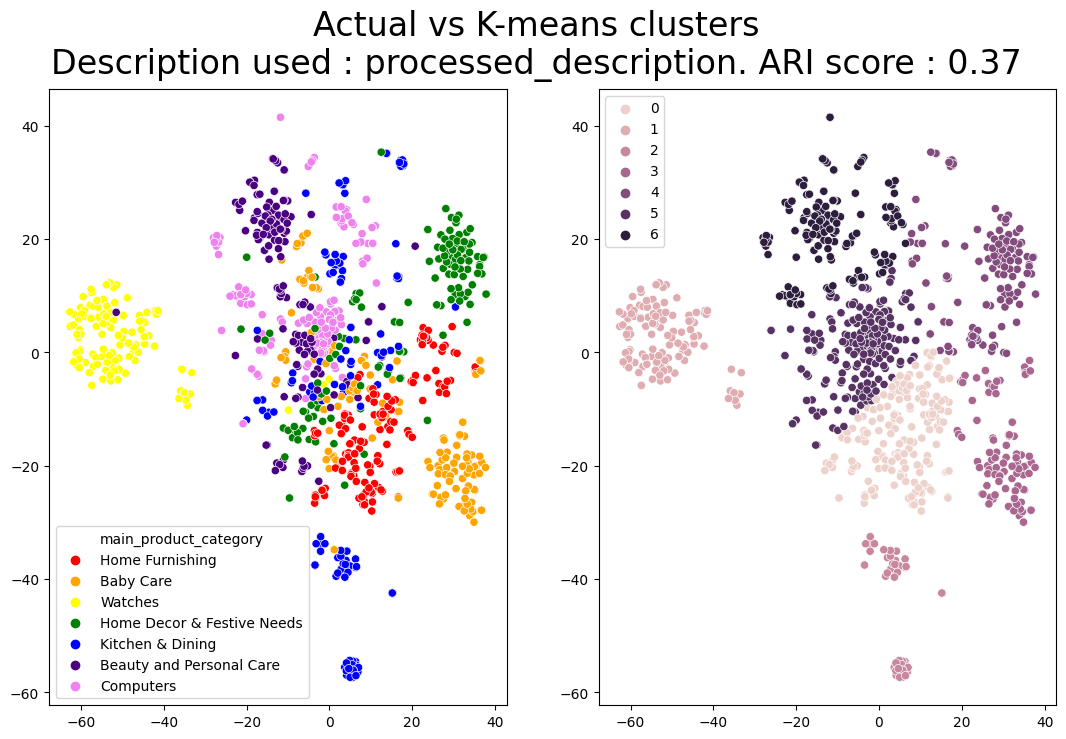

In [55]:
plot_clustering_results(df1, test_tsne, test_clusters, "processed_description")

# Experiments

- loop over all 3 "nlp preprocessing"
- loop over all "feature getters" O_o **TODO: add more - GloVe, BERT, USE etc.**

## TODO:

- if results aren't great maybe try hyperparam search the TSNE step also